In [1]:
#This is a starting point
#uncomment below to install merlin library
#!pip install merlin, nvtabular, merlin.models
#I had to downgrade keras to 12.2.0 there maybe issues regarding tensorflow in the future
#run lines below if you have also have an error ab not finding a keras package

#!pip uninstall keras
#!pip install keras==2.12.0


#These are the same imports from
#https://github.com/NVIDIA-Merlin/models/blob/main/examples/02-Merlin-Models-and-NVTabular-integration.ipynb
import os
import pandas as pd
import numpy as np
import nvtabular as nvt
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import polars as pl

from sklearn.model_selection import train_test_split

from merlin.models.utils.example_utils import workflow_fit_transform
import merlin.io
import tensorflow as tf

import merlin.models.tf as mm
from merlin.io.dataset import Dataset
from nvtabular.ops import *
from merlin.core.utils import download_file
from merlin.schema.tags import Tags

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/dtypes/mappings/triton.py:53: UserWarning: Triton dtype mappings did not load successfully due to an error: No module named 'tritonclient'
  warn(f"Triton dtype mappings did not load successfully due to an error: {exc.msg}")


### To-do

1. Clean data << Prices on user_interactions are not what they should be... probably is more
2. EDA
3. Transform timestamps
4. Find out why certain things are crashing the model
5. Learn about models and optimizers

In [2]:
df = pd.read_csv('/Users/andrew/Desktop/projects/recsys_data/2023-10-05 9_23pm (2).csv').dropna() 
#After cleaning should not need dropna()
df['TARGET'] = 0
#Different values for different event_names
df.loc[df['EVENT_NAME'] == 'order', 'TARGET'] = 3
df.loc[df['EVENT_NAME'] == 'product_added', 'TARGET'] = 2
df.loc[df['EVENT_NAME'] == 'product_viewed', 'TARGET'] = 1

# Cleaning

In [3]:
df = df.sample(40000, random_state = 101)

In [4]:
df.columns

Index(['USER_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME',
       'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
       'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT', 'DAYS_SINCE_FIRST_VISIT',
       'DAYS_SINCE_FIRST_PURCHASE', 'DAYS_SINCE_LAST_VISIT',
       'DAYS_SINCE_LAST_PURCHASE', 'RECENT_VISIT', 'UNIQUE_PURCHASE_COUNT',
       'MULTIPLE_BUYER', 'EVENT_NAME', 'EVENT_TIMESTAMP', 'ITEM_ID',
       'PRICE_INFORMATION', 'DAYS_SINCE_INTERACTION', 'AVG_REVIEW_SCORE',
       'STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
       'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'TARGET'],
      dtype='object')

# TRANSFORM USER DF

In [5]:
user_df = df[['USER_ID', 'ITEM_ID', 'COUNTRY', 'DERIVED_GENDER_BY_NAME', 'CLICKSTREAM_EVENTS_TOTAL', 'FIRST_PURCHASE_AT', 'FIRST_VISIT_AT',
              'LATEST_VISIT_AT', 'LATEST_PURCHASE_AT']]
user_df.head()

,USER_ID,ITEM_ID,COUNTRY,DERIVED_GENDER_BY_NAME,CLICKSTREAM_EVENTS_TOTAL,FIRST_PURCHASE_AT,FIRST_VISIT_AT,LATEST_VISIT_AT,LATEST_PURCHASE_AT
124660,9d6a69ce15fbae0784477025fb74ab20acf7520be62443...,color-womens-wool-runners,United States,F,94,2023-04-15T20:05:25Z,2023-04-11T05:12:38.335Z,2023-04-22T04:31:51.178Z,2023-04-15T20:05:25Z
1192744,6bc5690cbcbd167fcb9c09a35283b20b2f6eb9b80ad86b...,color-womens-tree-breezers,United States,F,8,2023-01-08T12:45:54Z,2023-05-22T00:25:54.273Z,2023-05-22T00:34:22.124Z,2023-01-08T12:45:54Z
437481,627358c6db8f6b2881adc8edcdffe73ba63f108d226abe...,color-womens-tree-breezers-jet-black,United States,F,612,2019-09-20T13:57:30Z,2021-11-30T00:34:09.12Z,2023-09-06T17:42:26.369Z,2023-09-06T17:42:22Z
688816,f97cf6c44e0510d3cbc7a3d83325468cbd22e8448a8a94...,color-womens-tree-breezers-navy-night,United States,F,394,2018-04-29T12:01:09Z,2021-11-28T01:09:43.945Z,2023-09-19T15:12:11.473Z,2023-09-09T21:02:37Z
392313,1788f7536113bea65641ea82101e16d678188167e78099...,color-womens-wool-runners-natural-black-thrive...,United States,F,492,2023-05-22T08:55:37Z,2023-05-21T05:38:57.982Z,2023-06-11T14:12:37.189Z,2023-05-30T22:45:42Z


In [6]:
#Add any ideas you have for each user

# TRANSFORM ITEM DF

In [7]:
item_df = df[['STYLE', 'USER_ID', 'PRICE_INFORMATION', 'AVG_REVIEW_SCORE',
              'ITEM_ID', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS',
              'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP', 'EVENT_NAME']]

item_df.head()

,STYLE,USER_ID,PRICE_INFORMATION,AVG_REVIEW_SCORE,ITEM_ID,TAXONOMY_STYLE,COLOR_NAME,PRODUCT_CLASS,PRODUCT_SUBCLASS,TEAM,FRANCHISE,PRODUCT_GROUP,EVENT_NAME
124660,womens-wool-runners,9d6a69ce15fbae0784477025fb74ab20acf7520be62443...,110.0,4.651220,color-womens-wool-runners,Wool Runner,Natural Grey (Light Grey),Footwear,Shoe,Womens,Runner,Lifestyle,product_viewed
1192744,womens-tree-breezers,6bc5690cbcbd167fcb9c09a35283b20b2f6eb9b80ad86b...,69.0,4.505155,color-womens-tree-breezers,Tree Breezer,Heathered Black,Footwear,Slip-On,Womens,Breezer,Lifestyle,cart_viewed
437481,womens-tree-breezers,627358c6db8f6b2881adc8edcdffe73ba63f108d226abe...,70.0,4.255132,color-womens-tree-breezers-jet-black,Tree Breezer,Jet Black (Black),Footwear,Shoe,Womens,Breezer,Lifestyle,cart_viewed
688816,womens-tree-breezers,f97cf6c44e0510d3cbc7a3d83325468cbd22e8448a8a94...,100.0,4.111111,color-womens-tree-breezers-navy-night,Tree Breezer,Navy Night (Dark Navy),Footwear,Shoe,Womens,Breezer,Lifestyle,product_viewed
392313,womens-wool-runners,1788f7536113bea65641ea82101e16d678188167e78099...,89.0,4.571429,color-womens-wool-runners-natural-black-thrive...,Wool Runner,Natural Black (Thrive Teal),Footwear,Shoe,Womens,Runner,Lifestyle,product_viewed


In [8]:
#Make sure these don't have weird 0 values (like num product_viewed < order), if they do get rid of them especially the last function

In [9]:
def count_product_views(df):
    """
    count num of times each user has viewed a unique STYLE
    
    return: a new column with the count of product views appended to each unique USER_ID and STYLE combination
    """
    return ...

In [10]:
def bought_ratio(df):
    """
    for each unique item how many people bought divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    return ...

In [11]:
def viewed_ratio(df):
    """
    for each unique item how many people viewed divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    return ...

In [12]:
def cart_ratio(df):
    """
    for each unique item how many people added cart divided by all people or len(unique(USER_ID))
    
    return: a new column with float proportion
    """
    return ...

In [13]:
def viewed_to_bought_ratio(df):
    """
    the number of views divided by bought... aka do people need to view it many times before buying it or not
    
    """
    return ...

## I am going to try and feature engineer on item_df and user_df then merge with negative sampled df.

## Also going to add in testing

In [36]:
negative_df = df[['USER_ID', 'ITEM_ID', 'TARGET']]

In [37]:
sections = df.shape[0]//10000
negative_data = []
item_map = df['ITEM_ID'].unique()
rng = np.random.default_rng()
zero_multiplier = 1 #https://datascience.stackexchange.com/questions/6939/ratio-of-positive-to-negative-sample-in-data-set-for-best-classification
#The above datascience stackexchange says 1:1 is a good ratio, i didn't look into it that much tho

for chunk in np.array_split(df, sections):
    user_id_counts = pd.value_counts(chunk.USER_ID)
    item_ids = []
    for user_id, count in user_id_counts.items():
        item_ids.append(np.random.randint(low = 0, high = item_map.shape[0], size = count*zero_multiplier))
    item_ids = np.concatenate(item_ids)
    negative_data.append(pd.DataFrame({'USER_ID': np.repeat(user_id_counts.index, repeats = user_id_counts.values*zero_multiplier),
                                       'ITEM_ID': item_map[item_ids],
                                       'TARGET': 0}))
negative_data.append(negative_df)
sample_data = pd.concat(negative_data)
sample_data = sample_data.reset_index(drop = True)

In [38]:
#it was a battle to merge user info and item info with negatively sampled df can't promise its 100% correct

### Merging TEST IN FUTURE

In [42]:
df_subset = sample_data.merge(user_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['USER_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')
df_subset = df_subset.merge(item_df, on = ['USER_ID', 'ITEM_ID'], how = 'outer').sort_values(['ITEM_ID', 'TARGET'], ascending=False).drop_duplicates(subset = ['USER_ID', 'ITEM_ID']).fillna(method='bfill')

In [45]:
#num rows
data_size = df_subset.shape[0]

train_split_ratio = int(.2 * data_size)

train = df_subset[:-train_split_ratio].to_parquet("train.parquet")
valid = df_subset[-train_split_ratio:].to_parquet("valid.parquet")

In [49]:
len(sample_data[sample_data['TARGET'] > 0])/len(sample_data)

80000

# EDA

# NVTabular

In [122]:
categorical_user_features = ['COUNTRY']
categorical_item_features = ['STYLE', 'TAXONOMY_STYLE', 'COLOR_NAME', 'PRODUCT_CLASS', 'PRODUCT_SUBCLASS', 'TEAM', 'FRANCHISE', 'PRODUCT_GROUP']

In [124]:
#DON'T FORGET TARGET ENCODING CATEGORICAL VALUES

In [125]:
user_id = ["USER_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsUserID()
item_id = ["ITEM_ID"] >> Categorify(dtype = "int32", out_path='categories') >> TagAsItemID()

target = (
    #Turn categorical into continuous
    nvt.ColumnSelector(["TARGET"])
    #>> LambdaOp(lambda col: (col > 0).astype("int32")) CHANGES ALL WEIGHTS TO 1 
    >> AddTags(["binary_classification", "target"])
    >> Rename(name="INTERACTION_BINARY")
)

item_features = categorical_item_features >> Categorify(dtype = "int32") >> TagAsItemFeatures()
user_features = categorical_user_features >> Categorify(dtype = "int32") >> TagAsUserFeatures()

In [126]:
#Make this more succinct
CLICKSTREAM_EVENTS_TOTAL = (
    nvt.ColumnSelector(['CLICKSTREAM_EVENTS_TOTAL'])
    >>FillMissing(1)
    >>LogOp()
    >>Normalize()
    >>LambdaOp(lambda col: col.astype("float32"))
    >>TagAsUserFeatures()
)

#has the price changed over time?
PRICE_INFORMATION = (
    ['PRICE_INFORMATION']
    >>FillMissing(1)
    >>LogOp()
    >>Normalize()
    >>LambdaOp(lambda col: col.astype("float32"))
    >>TagAsItemFeatures()
)

AVG_REVIEW_SCORE = (
    ['AVG_REVIEW_SCORE']
    >>Normalize()
    >>LambdaOp(lambda col: col**2)
    >>TagAsItemFeatures()
)

INTERACTION_TIMESTAMP = (
    nvt.ColumnSelector(['DAYS_SINCE_INTERACTION'])
    #>>Normalize()
    >>TagAsUserFeatures()
)

DAYS_SINCE_LAST_VISIT = (
    nvt.ColumnSelector(['DAYS_SINCE_LAST_VISIT'])
    >>TagAsUserFeatures()
)


In [127]:
categorical_features = (categorical_item_features) #Just a place holder... redo with better categories
user_cat_features = (user_features)
label = nvt.ColumnSelector(['TARGET'])
te_features = categorical_features >> TargetEncoding(label)
user_feats = user_cat_features >> TargetEncoding(label)
te_features_norm = te_features >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()
user_cat_features_norm = user_feats >> Normalize() >> LambdaOp(lambda col: col.astype('float32')) >> TagAsItemFeatures()

In [128]:
output = (
    user_id + 
    item_id +
    target +
    CLICKSTREAM_EVENTS_TOTAL + 
    te_features +
    user_feats +
    # INTERACTION_TIMESTAMP +
    DAYS_SINCE_LAST_VISIT + 
    #PRICE_INFORMATION + #<< THIS CAUSES MODEL TO CRASH AND BURN
    AVG_REVIEW_SCORE
)

workflow_fit_transform(output, 'train.parquet', 'valid.parquet', 'integration') #< What is integration

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Datase

In [75]:
train = merlin.io.Dataset(
    os.path.join("integration", "train"), engine="parquet"
)
valid = merlin.io.Dataset(
    os.path.join("integration", "valid"), engine="parquet"
)

/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(
/Users/andrew/anaconda3/lib/python3.11/site-packages/merlin/io/dataset.py:267: UserWarning: Initializing an NVTabular Dataset in CPU mode.This is an experimental feature with extremely limited support!
  warnings.warn(


<Axes: >

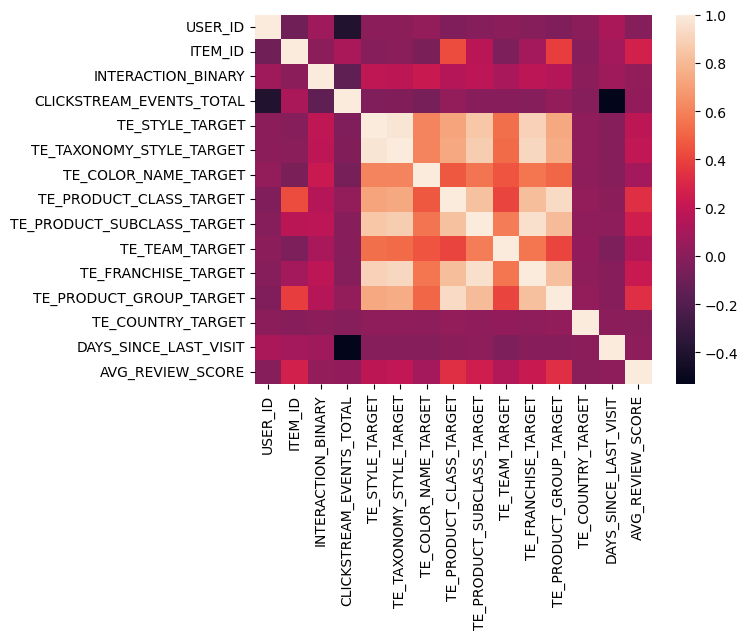

In [76]:
data = pl.read_parquet('integration/train/part_0.parquet').to_pandas().corr()
sns.heatmap(data)

In [77]:
data

,USER_ID,ITEM_ID,INTERACTION_BINARY,CLICKSTREAM_EVENTS_TOTAL,TE_STYLE_TARGET,TE_TAXONOMY_STYLE_TARGET,TE_COLOR_NAME_TARGET,TE_PRODUCT_CLASS_TARGET,TE_PRODUCT_SUBCLASS_TARGET,TE_TEAM_TARGET,TE_FRANCHISE_TARGET,TE_PRODUCT_GROUP_TARGET,TE_COUNTRY_TARGET,DAYS_SINCE_LAST_VISIT,AVG_REVIEW_SCORE
USER_ID,1.000000,-0.094187,0.073738,-0.397764,0.012445,0.009079,0.032471,-0.040410,-0.014204,0.006326,-0.012277,-0.040904,0.001554,0.120042,-0.012710
ITEM_ID,-0.094187,1.000000,0.009597,0.119243,-0.015115,-0.004867,-0.051963,0.426030,0.172119,-0.046046,0.090693,0.380731,-0.006137,0.092906,0.269598
INTERACTION_BINARY,0.073738,0.009597,1.000000,-0.153743,0.187424,0.184450,0.225489,0.146231,0.176748,0.103927,0.177208,0.149301,0.002915,0.075162,0.031999
CLICKSTREAM_EVENTS_TOTAL,-0.397764,0.119243,-0.153743,1.000000,-0.039270,-0.034305,-0.065371,0.035884,-0.009750,-0.007083,-0.012902,0.034846,-0.014839,-0.531920,0.026887
TE_STYLE_TARGET,0.012445,-0.015115,0.187424,-0.039270,1.000000,0.974728,0.608088,0.722958,0.855989,0.537867,0.893899,0.738791,0.020208,-0.016453,0.182835
TE_TAXONOMY_STYLE_TARGET,0.009079,-0.004867,0.184450,-0.034305,0.974728,1.000000,0.609587,0.740138,0.876655,0.526704,0.916585,0.752955,0.020669,-0.015680,0.192190
TE_COLOR_NAME_TARGET,0.032471,-0.051963,0.225489,-0.065371,0.608088,0.609587,1.000000,0.462572,0.554032,0.453765,0.560558,0.506811,0.013753,-0.015811,0.088416
TE_PRODUCT_CLASS_TARGET,-0.040410,0.426030,0.146231,0.035884,0.722958,0.740138,0.462572,1.000000,0.827564,0.402084,0.815320,0.934070,0.030697,0.005921,0.335130
TE_PRODUCT_SUBCLASS_TARGET,-0.014204,0.172119,0.176748,-0.009750,0.855989,0.876655,0.554032,0.827564,1.000000,0.584524,0.956682,0.809104,0.022591,0.016341,0.254736
TE_TEAM_TARGET,0.006326,-0.046046,0.103927,-0.007083,0.537867,0.526704,0.453765,0.402084,0.584524,1.000000,0.560997,0.407274,0.026136,-0.041571,0.139379


## Model

In [78]:
import tensorflow as tf

recall = []
precision = []
rang = np.arange(1, 10)

model = mm.benchmark.NCFModel(
    train.schema,
    embedding_dim=64,
    mlp_block=mm.MLPBlock([128, 64]),
    prediction_tasks=mm.BinaryOutput(train.schema.select_by_tag(Tags.TARGET).column_names[0]),
)

loss=tf.keras.losses.BinaryCrossentropy()
model.compile(optimizer=keras.optimizers.Adam(learning_rate = .0175), loss = loss, run_eagerly=False, metrics=[tf.keras.metrics.Recall(name="recall"), tf.keras.metrics.Precision(name='precision')]);
model.fit(train, validation_data=valid, batch_size=8000, epochs = 1); #Less epochs, more accurate valid... less accurate train
model.evaluate(valid, batch_size = 1024, return_dict = True)

8/8 [==============================] - 0s 2ms/step - loss: 0.5175 - recall: 0.0000e+00 - precision: 0.0000e+00 - regularization_loss: 0.0000e+00 - loss_batch: 0.5061


{'loss': 0.5175250172615051,
 'recall': 0.0,
 'precision': 0.0,
 'regularization_loss': 0.0,
 'loss_batch': 0.43103060126304626}

In [79]:
preds = model.predict(valid, batch_size = 1024)

(array([2253., 3110., 1239.,  302.,  194.,  284.,   98.,  166.,  173.,
         181.]),
 array([0.01035655, 0.05045939, 0.09056222, 0.13066506, 0.1707679 ,
        0.21087073, 0.25097358, 0.29107639, 0.33117923, 0.37128207,
        0.41138491]),
 <BarContainer object of 10 artists>)

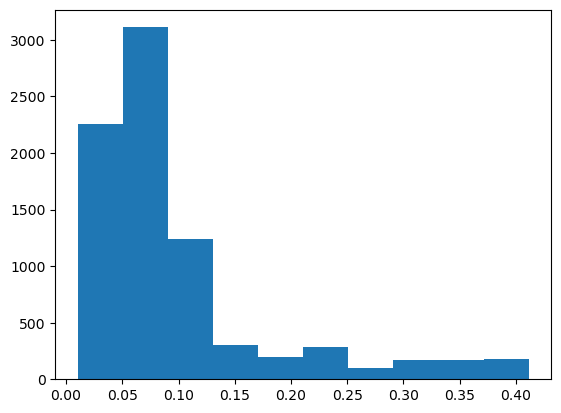

In [80]:
plt.hist(preds)

In [81]:
model.evaluate(valid, batch_size = 1024, return_dict = True)

8/8 [==============================] - 0s 2ms/step - loss: 0.5175 - recall: 0.0000e+00 - precision: 0.0000e+00 - regularization_loss: 0.0000e+00 - loss_batch: 0.5061


{'loss': 0.5175250172615051,
 'recall': 0.0,
 'precision': 0.0,
 'regularization_loss': 0.0,
 'loss_batch': 0.43103060126304626}

# Model

In [101]:
recall = []
precision = []

arr = [
    tf.keras.losses.BinaryCrossentropy(),
    tf.keras.losses.BinaryFocalCrossentropy(),
    tf.keras.losses.Hinge(),
    tf.keras.losses.SquaredHinge()
    
]

model_fb = mm.DLRMModel(
    train.schema,
    embedding_dim = 64,
    top_block = mm.MLPBlock([128, 64, 32]),
    bottom_block = mm.MLPBlock([128, 64]),
)
for i in np.arange(.01, .08, .01): 

    loss = arr[0]
    model_fb.compile(optimizer = keras.optimizers.Adam(learning_rate = i), loss = loss)
    model_fb.fit(train, batch_size = 1024, epochs = 1)
    x = model_fb.evaluate(valid, batch_size = 1024, return_dict = True)
    recall.append(x['auc'])

preds_2 = model_fb.predict(valid, batch_size = 1024)

8/8 [==============================] - 0s 2ms/step - loss: 2078902321152.0000 - precision: 0.1231 - recall: 0.6871 - binary_accuracy: 0.4843 - auc: 0.6089 - regularization_loss: 0.0000e+00 - loss_batch: 2206124751075.5557


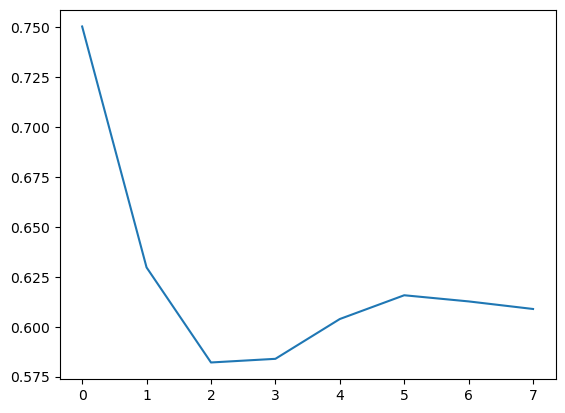

In [102]:
plt.plot(recall)

(array([2872., 3070.,  891.,  281.,  159.,  126.,   88.,  105.,  148.,
         260.]),
 array([8.07561330e-04, 1.00726701e-01, 2.00645834e-01, 3.00564975e-01,
        4.00484115e-01, 5.00403225e-01, 6.00322366e-01, 7.00241506e-01,
        8.00160646e-01, 9.00079787e-01, 9.99998927e-01]),
 <BarContainer object of 10 artists>)

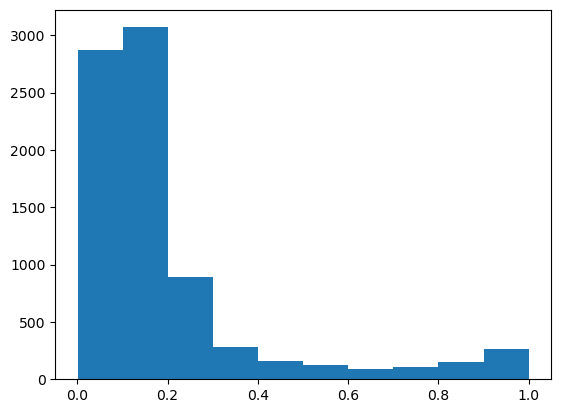

In [83]:
plt.hist(preds_2)

In [84]:
model_fb.evaluate(valid, batch_size = 1024, return_dict = True)

8/8 [==============================] - 0s 2ms/step - loss: 0.3580 - precision: 0.3077 - recall: 0.3200 - binary_accuracy: 0.8495 - auc: 0.7578 - regularization_loss: 0.0000e+00 - loss_batch: 0.3624


{'loss': 0.35804226994514465,
 'precision': 0.3076923191547394,
 'recall': 0.3199999928474426,
 'binary_accuracy': 0.8495000004768372,
 'auc': 0.7577516436576843,
 'regularization_loss': 0.0,
 'loss_batch': 0.3909563720226288}